<b><u>Observations</b></u>
<p>1. observation</p>
<p>2. observation</p>
<p>3. observation</p>

In [14]:
# Dependencies
import random
import json
import requests
from pprint import pprint
from config import api_key
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Wrapper for OpenWeatherMap
# Will use this to view sample JSON API response
import openweathermapy.core as owm

# Dependencies for downloading and uncompressing list of cities from OpenWeatherMap
import urllib.request
import gzip

# Set the seaborn chart style
sns.set()

# Increase the size of the bubble charts
plt.rcParams["figure.figsize"] = [10,8]

In [6]:
# Print out a sample JSON API response
settings = {"units": "imperial", "appid": api_key}
pprint(owm.get_current(2172797, **settings))

{'base': 'stations',
 'clouds': {'all': 90},
 'cod': 200,
 'coord': {'lat': -16.92, 'lon': 145.77},
 'dt': 1521907560,
 'id': 2172797,
 'main': {'humidity': 88,
          'pressure': 1007,
          'temp': 75.2,
          'temp_max': 75.2,
          'temp_min': 75.2},
 'name': 'Cairns',
 'sys': {'country': 'AU',
         'id': 8166,
         'message': 0.0043,
         'sunrise': 1521836492,
         'sunset': 1521879864,
         'type': 1},
 'visibility': 6000,
 'weather': [{'description': 'light intensity shower rain',
              'icon': '09n',
              'id': 520,
              'main': 'Rain'}],
 'wind': {'deg': 170, 'speed': 13.87}}


<h1>Download City List</h1>

In [3]:
# This section downloads the list of cities and IDs that OpenWeatherMap uses

# File names
city_index_zip_file = "city.list.json.gz"
city_index_json_file = 'city.list.json'

# Download file
urllib.request.urlretrieve ("http://bulk.openweathermap.org/sample/city.list.json.gz", city_index_zip_file)

# Uncompress gzip file to json
inF = gzip.open(city_index_zip_file, 'rb')
outF = open(city_index_json_file, 'wb')
outF.write(inF.read())
inF.close()
outF.close()

# Read json file into a dataframe
city_index_df = pd.read_json(city_index_json_file)

# Print top five rows
city_index_df.head()

,coord,country,id,name
0,"{'lon': 34.283333, 'lat': 44.549999}",UA,707860,Hurzuf
1,"{'lon': 37.666668, 'lat': 55.683334}",RU,519188,Novinki
2,"{'lon': 84.633331, 'lat': 28}",NP,1283378,GorkhÄ�
3,"{'lon': 76, 'lat': 29}",IN,1270260,State of HaryÄ�na
4,"{'lon': 33.900002, 'lat': 44.599998}",UA,708546,Holubynka


<h1>Generate City List</h1>

In [4]:
# This section selects 555 random cities from the above city index dataframe

# Start by creating an empty dataframe
random_city_df = pd.DataFrame(columns=['coord', 'country', 'id', 'name', 'lon', 'lat'])

# Set counter to zero for looping
counter = 0

# Set total number of random cities
total_cities = 555

# Loop while counter is less than number of cities
while counter < total_cities:
    
    # Pick a random row (must be length - 1 since row starts at 0)
    row = random.randint(0, len(city_index_df)-1)
    
    # If ID is already in the dataframe then do nothing repeat loop
    if any(random_city_df.id == city_index_df['id'][row]):
        pass
    
    # If ID isn't in the dataframe then add that row to the dataframe, including latitude and longitude
    else:
        random_city_df.loc[counter] = city_index_df.iloc[row,:]
        random_city_df.lat[counter] = city_index_df['coord'][row]['lat']
        random_city_df.lon[counter] = city_index_df['coord'][row]['lon']
        counter = counter + 1
        
# Change latitude and longitude columns from object to float
random_city_df[['lat','lon']] = random_city_df[['lat','lon']].apply(pd.to_numeric)

# Remove coordinate column, since we parsed out that data
del random_city_df['coord']

<h1>Weather API Call</h1>

In [5]:
# This section does the API calls from OpenWeatherMap

# Create empty lists for temperature, humidity, cloudiness and windspeed
# This will get added to the dataframe of cities
city_temp_list = []
city_humidity_list = []
city_cloudiness_list = []
city_windspeed_list = []

# Loop through the total number of cities
for index in range(total_cities):
    
    # Print out 
    print(f"Request {x+1} of {total_cities}: {random_city_df['name'][x]}")
    
    # Create and print out the URL
    url = "http://api.openweathermap.org/data/2.5/weather?APPID="+api_key+"&units=imperial&id="+str(random_city_df.id[index])
    print(url)

    # Do the API call
    response = requests.get(url)
    
    # Convert API response to JSON
    data = response.json()
    
    # Grab temperature, humidity, cloudiness and windspeed and add it to their respective list    
    city_temp_list.append(data['main']['temp'])
    city_humidity_list.append(data['main']['humidity'])
    city_cloudiness_list.append(data['clouds']['all'])
    city_windspeed_list.append(data['wind']['speed'])

    
# Add temperature, humidity, cloudiness and windspeed as a column in the dataframe
random_city_df['temp'] = city_temp_list
random_city_df['humidity'] = city_humidity_list
random_city_df['cloudiness'] = city_cloudiness_list
random_city_df['windspeed'] = city_windspeed_list

Request 1 of 555: Panbanqiao
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=1904748
Request 2 of 555: Rybie
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=759915
Request 3 of 555: South Orange
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=5104836
Request 4 of 555: Manis Subang
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=8059636
Request 5 of 555: Shunling
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=1799346
Request 6 of 555: AliÃ³
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=6361253
Request 7 of 555: Siedlinghausen
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2832582
Request 8 of 555: 

Request 59 of 555: Allaman
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=7285049
Request 60 of 555: GroÃŸenkneten
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=6552967
Request 61 of 555: Rumia
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=3086706
Request 62 of 555: Ogdensburg
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=5102153
Request 63 of 555: Russell County
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=4278472
Request 64 of 555: South Upi
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=1685692
Request 65 of 555: Bogliasco
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=3181943
Request 6

Request 117 of 555: Valverdejo
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=6357552
Request 118 of 555: Tabanera de Cerrato
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=3108464
Request 119 of 555: Cazalla de la Sierra
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=6360987
Request 120 of 555: Courtion
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2661088
Request 121 of 555: Calnali
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=3531789
Request 122 of 555: Katharinenheerd
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=6551562
Request 123 of 555: San Juan del Puerto
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f

Request 175 of 555: Pasirmukti
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=8045478
Request 176 of 555: Greenwood Park
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=1000065
Request 177 of 555: Neukirchen vorm Wald
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2864723
Request 178 of 555: Surkhet
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=7649119
Request 179 of 555: SÃ©es
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=6454473
Request 180 of 555: Karabas
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=1523470
Request 181 of 555: Maliiha
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=7411459

Request 233 of 555: Unterreit
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=6556305
Request 234 of 555: Richland Hills
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=4722668
Request 235 of 555: Noiseau
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2990195
Request 236 of 555: Sukawangi
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=7915079
Request 237 of 555: Bricia
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=3127636
Request 238 of 555: Kolganov
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=546448
Request 239 of 555: Old Saybrook Center
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=725739

Request 293 of 555: Bosenbach
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=6555079
Request 294 of 555: Shenavan
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=616231
Request 295 of 555: Ozolnieki
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=456954
Request 296 of 555: West Ocean City
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=4373153
Request 297 of 555: La Roche-sur-Foron
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=3006770
Request 298 of 555: Siekholz
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2832397
Request 299 of 555: Gwaram
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=233978

Request 352 of 555: Nea Filadelfeia
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=256621
Request 353 of 555: Konkan Division
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=8131499
Request 354 of 555: Mahalaua PoÅŸtei
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=674082
Request 355 of 555: Vale do ParaÃ­so
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=8014832
Request 356 of 555: Waringstown
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2634768
Request 357 of 555: Buchanan
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=4987238
Request 358 of 555: Aukstadvaris
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&unit

Request 411 of 555: Tit Mellil
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2527271
Request 412 of 555: Yokogawara
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=1926016
Request 413 of 555: Legokkopra
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=7766587
Request 414 of 555: Pupiales
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=3671228
Request 415 of 555: Villejuif
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2968705
Request 416 of 555: Avtoprokladka
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=6729232
Request 417 of 555: Salernes
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=6445066
R

Request 470 of 555: Breitenberg
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2944654
Request 471 of 555: Bersede
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2949907
Request 472 of 555: VÃ©drines
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2970248
Request 473 of 555: Western District
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=5880873
Request 474 of 555: Carbrook
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2172356
Request 475 of 555: Losar de la Vera
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=3118057
Request 476 of 555: Phuntsholing
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&i

Request 527 of 555: Cranes Nest
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=4754589
Request 528 of 555: Landigou
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=3007847
Request 529 of 555: Teulada
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=6355501
Request 530 of 555: Aidomaggiore
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=3183395
Request 531 of 555: Lorain
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=5161262
Request 532 of 555: Reinsdorf
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=2848716
Request 533 of 555: Rodi Garganico
http://api.openweathermap.org/data/2.5/weather?APPID=f794c4f97402e541fc87718afc020f36&units=imperial&id=3169094
Re

In [26]:
# Export city dataframe as CSV
random_city_df.to_csv("weather_data.csv", encoding='utf-8')

<h1>Print Charts</h1>

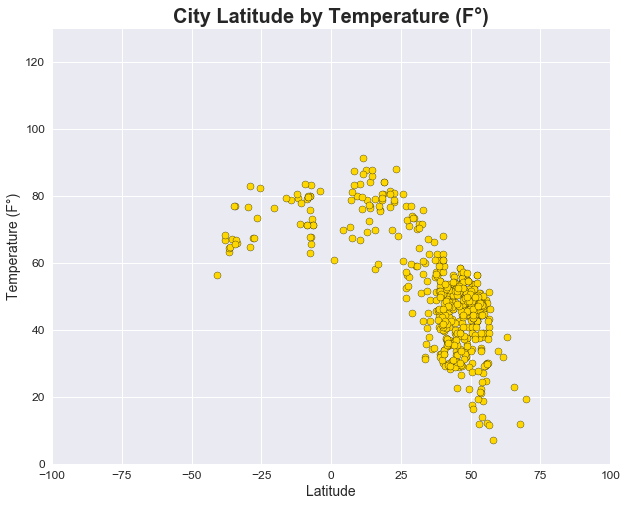

In [22]:
# This section prints a scatter plot of latitude by temperature

# Clear the plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], random_city_df['temp'], marker="o", facecolors='gold', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Temperature (F\N{DEGREE SIGN})", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Temperature (F\N{DEGREE SIGN})", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(0,130)

# Save the figure
plt.savefig("LatByTemp.png")

# Display scatter chart
plt.show()

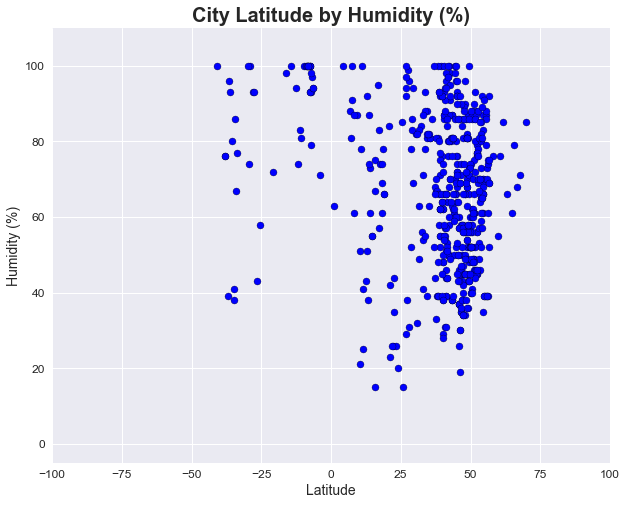

In [23]:
# This section prints a scatter plot of latitude by humidity

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], random_city_df['humidity'], marker="o", facecolors='blue', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Humidity (%)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Humidity (%)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,110)

# Save the figure
plt.savefig("LatByHumidity.png")

# Display scatter chart
plt.show()

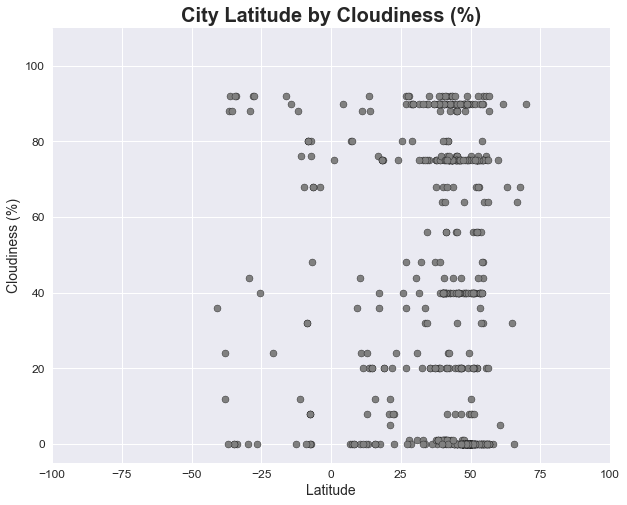

In [24]:
# This section prints a scatter plot of latitude by cloudiness

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], random_city_df['cloudiness'], marker="o", facecolors='gray', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Cloudiness (%)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Cloudiness (%)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,110)

# Save the figure
plt.savefig("LatByCloudiness.png")

# Display scatter plot
plt.show()

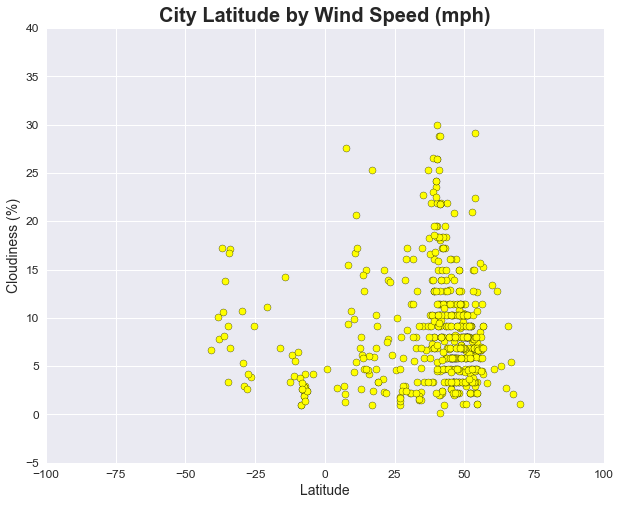

In [25]:
# This section prints a scatter plot of latitude by windspeed

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], random_city_df['windspeed'], marker="o", facecolors='yellow', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Wind Speed (mph)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Cloudiness (%)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,40)

# Save the figure
plt.savefig("LatByWindspeed.png")

# Display scatter plot
plt.show()